# Wikipedia Paragraphs Classifier

We chose to tackle a specific sub-category of wikipidia articles- Biographies. This approch allowes us to pick a most-common subset of paragraph titles to use as a target for a supervised classifier. After collecting a good amount of data to be used both as train and test datasets, we wanted to identify which subset of titles will gain us the best possiable results.

When dealing with large datasets, we'd allways prefer using an out-of-core processing approch. That is, processing each data item seperetly, updating the current model using the processed data, and then moving on to deal with the next item. Here is a function which uses yield to do just that (to be later used by other functions):

In [1]:
import pickle

TRAIN_PICKLE_PATH = "Wikidumps/train-corpus/"
TEST_PICKLE_PATH = "Wikidumps/test-corpus/"

# generates a filename list
def generate_filename_list(path, start, end):
    filename = [path + "corpus" + str(i) + "000.pickle" for i in range(start, end+1)]
    return filename

# a lazy loader for picle files
def lz_pickle_loader(files):
    for file in files:
        curr_file = pickle.load(open(file, "rb" ))
        yield curr_file

# a lazy loader which loads a list of wikipedia articles from a given list of pickle files
def lz_article_loader(filenames):
    files = lz_pickle_loader(filenames)
    for file in files:
        for article in file:
            yield article

As a base model, we've began with a simple configuration of hashing vectorizer and a naive bayes classifier. To deal with the format of the parsed wikipedia articles, we've wrapped sklearn's built-in tf-idf classifier implamentation so it can access the article's text directly.

* note that we could'nt use sklean's pipeline implemantation, since it dosn't support partial-fit functionality.
* note that we useally got the best results when using unigrams and setting max_df (that is, a maximum frquency of a token) to 5%.

In [38]:
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

# wrapper for TfIdfVectorizer
# expects to get an iterable list of articles during fit/transform
class TfidfWrapper(TransformerMixin):
    def __init__(self):
        self.__tfidf_vect__ = TfidfVectorizer(max_df=0.05, ngram_range=(1, 1))

    def fit(self, articles):
        acc_par = []
        for [(article, pars)] in articles:
            for t, p in pars:
                acc_par.append(p)
        self.__tfidf_vect__.fit(acc_par)
        return self

    def transform(self, article):
        pars = [p for t, p in article]
        return self.__tfidf_vect__.transform(pars)

In order to use partial-fit, our classifier needs to know the the class list in advance. Since we are dealing with a specific category of wikipedia articles, we expect to see a subset of extrermly common paragraph titles- which will serve as our classes. Generaly, we expect to have a long-tail form- with a few very common paragraph titles, and a long tail of rare titles.
To identify the right set of paragraph titles, we'll plot the title's distribution-

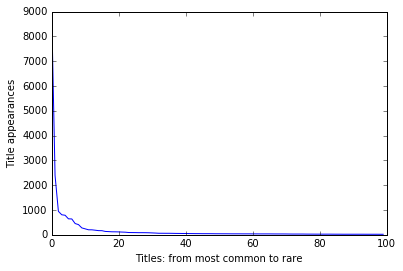

In [5]:
%matplotlib inline
import matplotlib.pyplot as py
from nltk import FreqDist, ConditionalFreqDist

# extract a list of topics out of a given formatted dataset
def extract_tags(data):
    tags = []
    for [(article, pars)] in data:
        tags += [t for (t, a) in pars]
    return tags

# plots N most common topics from a givven dataset
def plot_topics(tags, N):
    X_LABEL = "Titles: from most common to rare"
    Y_LABEL = "Title appearances"
    fd = FreqDist(tags)
    raw = fd.most_common(N)
    X_axis = list(range(N))
    Y_axis = [y for (x,y) in raw]
    py.plot(X_axis, Y_axis)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.show()

# ploting distribution of 100 most common topics
train_filenames = generate_filename_list(TRAIN_PICKLE_PATH ,1, 10) # filenames for 10k articles
train = lz_article_loader(train_filenames) # create generator
raw_tags = extract_tags(train) # extract tag list
plot_topics(raw_tags, 100)

We can clearly see that a long-tail pattern begins after around 40 titles. To improve our preformences, we'll reduce pereplexity by only using 20 most-common titles. Next step is to find-out the 20 most common titles-

In [8]:
# extracts N most common topics out of a given tag list
def extract_most_common_tags(tag_list, N):
    fd = FreqDist(tag_list)
    most_common = [X for X, Y in list(fd.most_common(N))]
    return most_common

tags = extract_most_common_tags(raw_tags, 20)
print(tags)

['Summary', 'Biography', 'Career', 'Legacy', 'Death', 'Life', 'Works', 'Family', 'Bibliography', 'Awards', 'Discography', 'Honours', 'Filmography', 'Books', 'Publications', 'Education', 'Background', 'Ancestry', 'Novels', 'Television']


We are ready to train our classifier. We'll test with 2 different sklearn implementations- Multinomial Naive-Bayes and SGD.

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron

def train_classifier(vectorizer, classifier, train_filenames, classes):
    train = lz_article_loader(train_filenames)
    for [(title, pars)] in train:
        if(len(pars) > 0):
            X_data = vectorizer.transform(pars)
            Y_data = [t for t, a in pars]
            classifier.partial_fit(X_data, Y_data, classes)
    return classifier

train = lz_article_loader(train_filenames) # get train data
tf_idf_vectorizer = TfidfWrapper() # create vectorizer
tf_idf_vectorizer.fit(train) # train vectorizer

nb_classifier = train_classifier(tf_idf_vectorizer, MultinomialNB(), train_filenames, tags) # train nb classifier
sgd_classifier = train_classifier(tf_idf_vectorizer, SGDClassifier(), train_filenames, tags) # train sgd classifier
passive_aggressive_classifier = train_classifier(tf_idf_vectorizer, PassiveAggressiveClassifier(), train_filenames, tags) # train passive-aggressive classifier
preceptron_classifier = train_classifier(tf_idf_vectorizer, Perceptron(), train_filenames, tags) # train preceptron classifier

C:\Users\YUVAL\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:420: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_)


Next, we'll test the results for using only the tf-idf vectorizer and both of the classifiers. We'll use a dataset of 2000 articles (20% of train dataset size)-

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def test_classifier(vectorizer, classifier, classes, test_filenames):
    test = lz_article_loader(test_filenames)
    true_classes = []
    predictions = []
    for [(article, parms)] in test:
        true_classes += [t for (t, p) in parms]
        predictions += classifier.predict(vectorizer.transform(parms)).tolist()

    print("Precision: " + str(precision_score(true_classes, predictions, average='micro')))
    print("Recall: " + str(recall_score(true_classes, predictions, average='micro')))
    print("F-measure: " + str(f1_score(true_classes, predictions, average='micro')))
    print(classes)
    np.set_printoptions(threshold=np.nan)
    print(confusion_matrix(true_classes, predictions, labels=classes))

    
test_filenames = generate_filename_list(TRAIN_PICKLE_PATH ,11, 12) # filenames for 2k articles

test = lz_article_loader(test_filenames) # create generator
print("[NB Classifier]")
test_classifier(tf_idf_vectorizer, nb_classifier, tags, test_filenames)

test = lz_article_loader(test_filenames) # recreate generator
print("[SGD Classifier]")
test_classifier(tf_idf_vectorizer, sgd_classifier, tags, test_filenames)

test = lz_article_loader(test_filenames) # recreate generator
print("[Passive-Aggressive Classifier]")
test_classifier(tf_idf_vectorizer, passive_aggressive_classifier, tags, test_filenames)

test = lz_article_loader(test_filenames) # recreate generator
print("[Preceptron Classifier]")
test_classifier(tf_idf_vectorizer, preceptron_classifier, tags, test_filenames)

[NB Classifier]
Precision: 0.348710990502
Recall: 0.348710990502
F-measure: 0.348710990502
['Summary', 'Biography', 'Career', 'Legacy', 'Death', 'Life', 'Works', 'Family', 'Bibliography', 'Awards', 'Discography', 'Honours', 'Filmography', 'Books', 'Publications', 'Education', 'Background', 'Ancestry', 'Novels', 'Television']
[[1794    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 465    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 190    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 131    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 157    0    0    0    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 122    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 105    1    0    0    0    0    0    0  

We can clearly see that the Passive-Aggressive classifier provides a far better results then both NB classifier and the Preceptron, and a little beter then the SGD classifier. We'll continue using it for this task.
Next, we'd like to add more features to our vectorizer in-order to improve our results.
By observing the confusion matrix, we'll notice that the following mistakes made by the classifier are mostly common-

[should be] > [replaced by] (#mistakes)

- Biography > Summary (160)
- Summary > Biography (75)
- Life > Biography (74)
- Biography > Career (55)
- Legacy > Summary (48)
- Family > Summary (44)
- Career > Summary (40)

A few easy-to-spot observations:
* Summary and Biography tends to overfit
* Summary and Biography are not easily distinguished from one another.
* All numbers in the matrix sums up to 3574.
* Since our confusion matrix is ordered from most-common title to most rare, it is much more dense at it's origin (top-left corner).
* We are very bad at recognizing some of the less common titles, but on the grand scale, these are a bit less important (since they only sum up to a small portion of titles).

Next, we'll try to identify some unique features of the less-easy-to-distinguish titles. Starting from the paragraph's relative length-

[Summary vs. Biography]


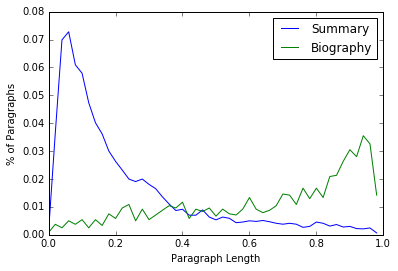

[Biography vs. Life]


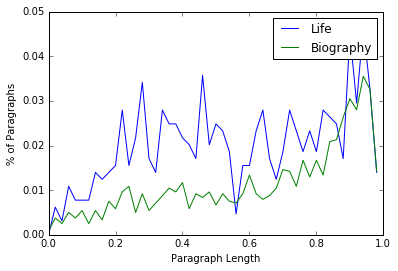

[Biography vs. Career]


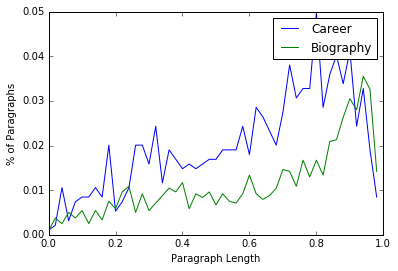

[Summary vs. Legacy]


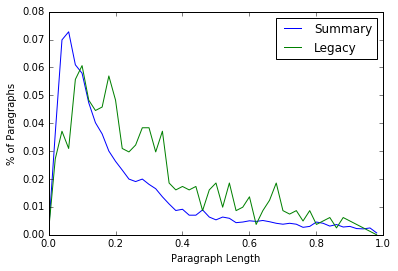

[10 most common tags]


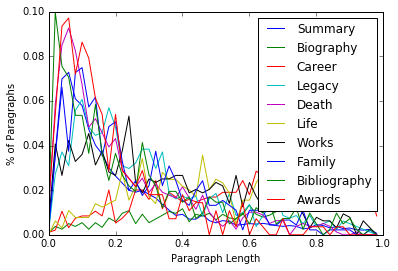

In [44]:
def plot_by_length(data_filenames, tags, buckets=100): # length = num of words
    X_LABEL = "Paragraph Length"
    Y_LABEL = "% of Paragraphs"
    for tag in tags:
        data = lz_article_loader(data_filenames)
        len_list = []
        for [(title, article)] in data:
            curr_len_list = []
            article_len = 0
            for (t, a) in article:
                par_len = len(a.split())
                if(t == tag):
                    curr_len_list.append(par_len)
                article_len += par_len
            len_list += [round(buckets*x/article_len) for x in curr_len_list]
        fd = FreqDist(len_list)
        total_amount = len(len_list)
        X_cord = [x/buckets for x in range(buckets)]
        Y_cord = [fd[x]/total_amount for x in range(buckets)]
        py.plot(X_cord, Y_cord, label=tag)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()
    
print("[Summary vs. Biography]")
plot_by_length(train_filenames, ['Summary', 'Biography'], 50)

print("[Biography vs. Life]")
plot_by_length(train_filenames, ['Life', 'Biography'], 50)

print("[Biography vs. Career]")
plot_by_length(train_filenames, ['Career', 'Biography'], 50)

print("[Summary vs. Legacy]")
plot_by_length(train_filenames, ['Summary', 'Legacy'], 50)

print("[10 most common tags]")
plot_by_length(train_filenames, tags[:10], 50)

We can see that by using normalized length we can indeed distinguish Summary from Biography. The difference is a bit less noticeale when examining other categories; Life is at most shorter then Biography, but the difference is not as clear. By looking at the graphs of 10 most common titles, we can roughly devide the paragraphs into two subgroups: mostly short (Summar, Family, Death...) and mostly long (Biography, Life, Career...).

We'll move on to exemine another aspect of a paragraph - it's reletive location in the article-

[Summary vs. Biography]


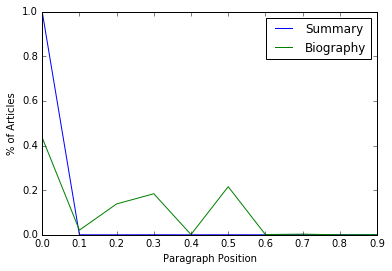

[Biography vs. Life]


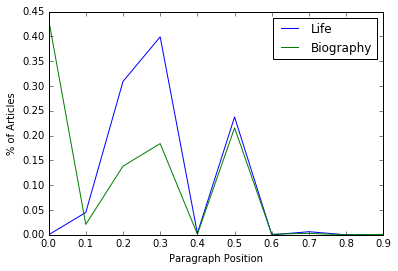

[Biography vs. Career]


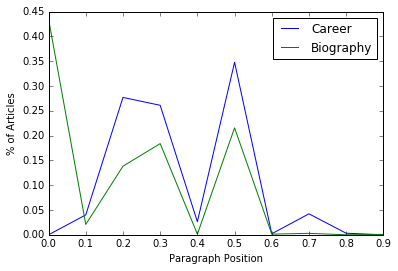

[Summary vs. Legacy]


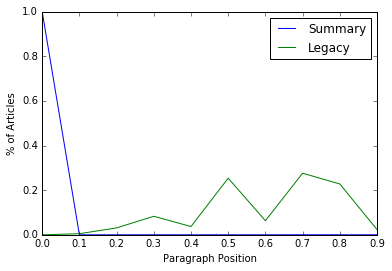

[10 most common tags]


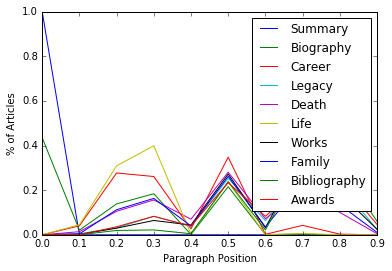

In [51]:
def plot_position_in_artical(data_filenames, tag_list, buckets):
    X_LABEL = "Paragraph Position"
    Y_LABEL = "% of Articles"
    for tag in tag_list:
        data = lz_article_loader(data_filenames)
        raw_pos = []
        for [(title, article)] in data:
            for i, (t, a) in enumerate(article):
                if(t == tag):
                    raw_pos.append(round(buckets*i/len(article)))
        fd = FreqDist(raw_pos)
        total_amount = len(raw_pos)
        X_cord = [x/buckets for x in range(buckets)]
        Y_cord = [fd[x]/total_amount for x in range(buckets)]
        py.plot(X_cord, Y_cord, label=tag)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

print("[Summary vs. Biography]")
plot_position_in_artical(train_filenames, ['Summary', 'Biography'], 10)

print("[Biography vs. Life]")
plot_position_in_artical(train_filenames, ['Life', 'Biography'], 10)

print("[Biography vs. Career]")
plot_position_in_artical(train_filenames, ['Career', 'Biography'], 10)

print("[Summary vs. Legacy]")
plot_position_in_artical(train_filenames, ['Summary', 'Legacy'], 10)

print("[10 most common tags]")
plot_position_in_artical(train_filenames, tags[:10], 10)

We can see that, as in the previous case, a paragraph's relative position helps to identify specific paragraphs (it's easy to see that in all cases, if an article has a summary it will always appear as it's first paragraph. In addition, in  many cases Biography will show as the first paragraph. The beheivour seems to be less expected for other types of paragraphs).

Next, we'll move to inspect some interior features of the text, such as appearence of specific expressions. We'll start with numbers which represent years:

[Summary vs. Biography]


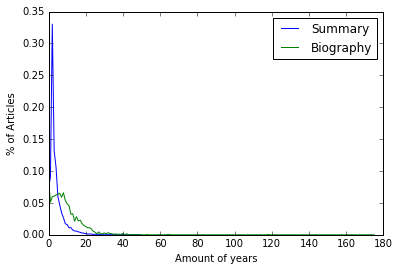

[Biography vs. Life]


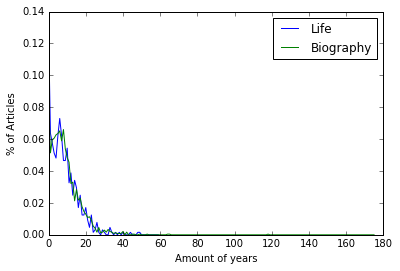

[Biography vs. Career]


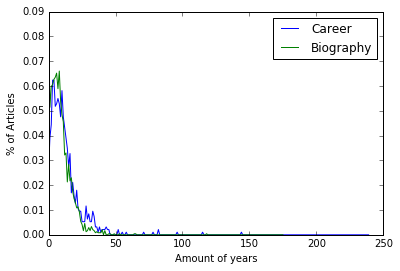

[Summary vs. Legacy]


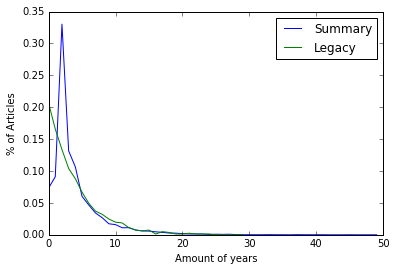

[Awards vs. Summary]


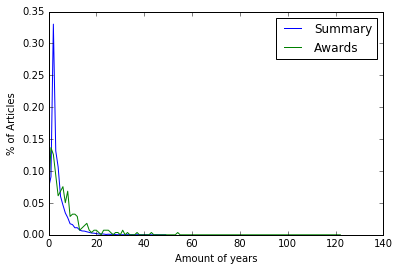

[10 most common tags]


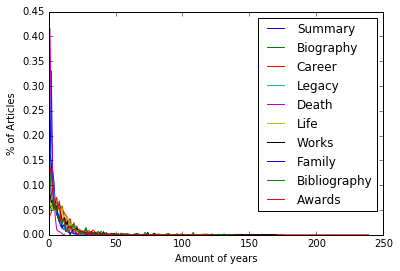

In [60]:
def plot_amount_of_dates(data_filenames, tags): #looks for years of shape YYYY
    X_LABEL = "Amount of years"
    Y_LABEL = "% of Articles"
    for tag in tags:
        data = lz_article_loader(data_filenames)
        amount_list = []
        max = 0
        cat_num = 0
        for [(title, doc)] in data:
            for (t, p) in doc:
                if t == tag:
                    dates = re.findall("[^0-9][0-2][0-9]{3,3}[^0-9]", p)
                    amount = len(dates)
                    amount_list.append(amount)
                    if(amount > max):
                        max = amount
                    cat_num += 1
        fd = FreqDist(amount_list)
        X_axis = list(range(max))
        Y_axis = [fd[x]/ cat_num for x in X_axis]
        py.plot(X_axis, Y_axis, label=tag)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

print("[Summary vs. Biography]")
plot_amount_of_dates(train_filenames, ['Summary', 'Biography'])

print("[Biography vs. Life]")
plot_amount_of_dates(train_filenames, ['Life', 'Biography'])

print("[Biography vs. Career]")
plot_amount_of_dates(train_filenames, ['Career', 'Biography'])

print("[Summary vs. Legacy]")
plot_amount_of_dates(train_filenames, ['Summary', 'Legacy'])

print("[Awards vs. Summary]")
plot_amount_of_dates(train_filenames, ['Summary', 'Awards'])

print("[10 most common tags]")
plot_amount_of_dates(train_filenames, tags[:10])

And again, we see a beaheviour that mostly distinguishes summary from other categories (although baiography and categories which tends to have lists, such as 'awards', are also noticable). We'll try identify some other text features -

[Summary vs. Biography]


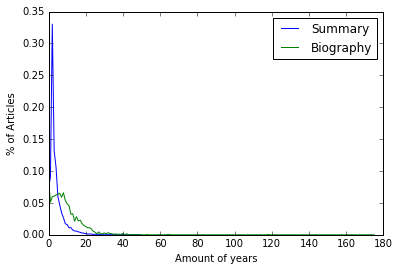

[Biography vs. Life]


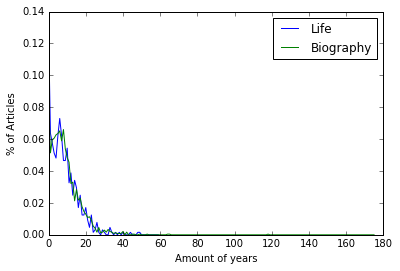

[Biography vs. Career]


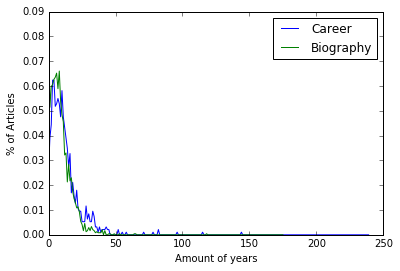

[Summary vs. Legacy]


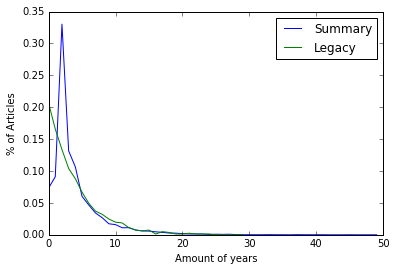

[Awards vs. Summary]


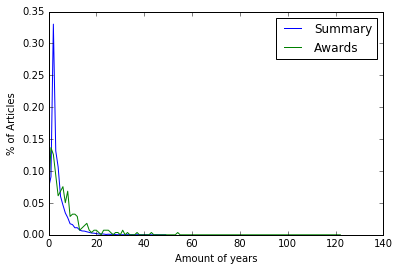

[10 most common tags]


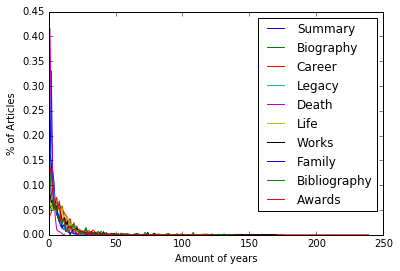

In [61]:
def plot_amount_of_stars(data_filenames, tags): # looks for 'points'
    X_LABEL = "Amount of stars"
    Y_LABEL = "% of Articles"
    for tag in tags:
        data = lz_article_loader(data_filenames)
        amount_list = []
        max = 0
        cat_num = 0
        for [(title, doc)] in data:
            for (t, p) in doc:
                if t == tag:
                    stars = re.findall("[\n][*]", p)
                    amount = len(stars)
                    amount_list.append(amount)
                    if(amount > max):
                        max = amount
                    cat_num += 1
        fd = FreqDist(amount_list)
        X_axis = list(range(max))
        Y_axis = [fd[x]/ cat_num for x in X_axis]
        py.plot(X_axis, Y_axis, label=tag)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

print("[Summary vs. Biography]")
plot_amount_of_dates(train_filenames, ['Summary', 'Biography'])

print("[Biography vs. Life]")
plot_amount_of_dates(train_filenames, ['Life', 'Biography'])

print("[Biography vs. Career]")
plot_amount_of_dates(train_filenames, ['Career', 'Biography'])

print("[Summary vs. Legacy]")
plot_amount_of_dates(train_filenames, ['Summary', 'Legacy'])

print("[Awards vs. Summary]")
plot_amount_of_dates(train_filenames, ['Summary', 'Awards'])

print("[10 most common tags]")
plot_amount_of_dates(train_filenames, tags[:10])

[Summary vs. Biography]


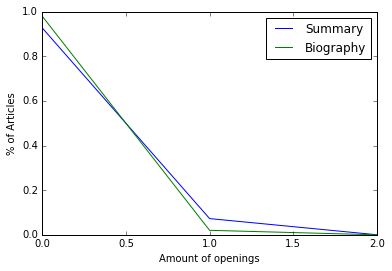

[Biography vs. Life]


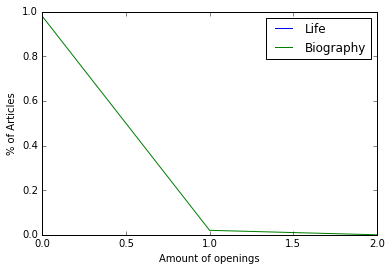

[Biography vs. Career]


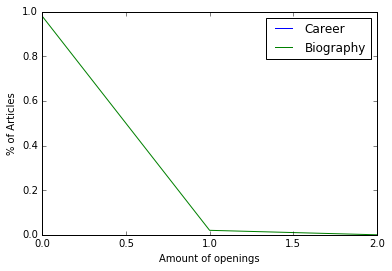

[Summary vs. Legacy]


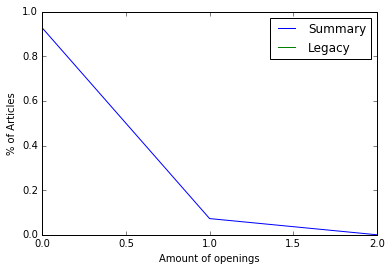

[Awards vs. Summary]


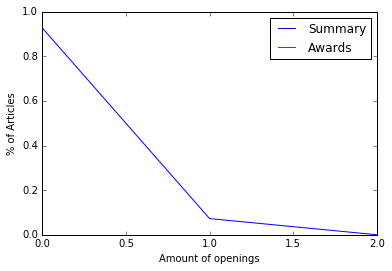

[10 most common tags]


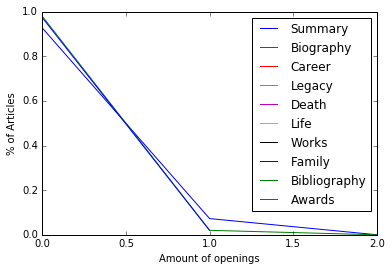

In [144]:
def plot_biography_openings(data_filenames, tags): # looks for 'openings'
    X_LABEL = "Amount of openings"
    Y_LABEL = "% of Articles"
    for tag in tags:
        data = lz_article_loader(data_filenames)
        amount_list = []
        max = 0
        cat_num = 0
        for [(title, doc)] in data:
            for (t, p) in doc:
                if t == tag:
                    months = "January|February|March|April|May|June|July|August|September|October|November|December"
                    years = "[^0-9][0-2][0-9]{3,3}[^0-9]"
                    openings = re.findall("([0-9] ("+months+")"+years+" ([0-9] ("+months+")"+years+"))", p)
                    amount = len(openings)
                    amount_list.append(amount)
                    if(amount > max):
                        max = amount
                    cat_num += 1
        fd = FreqDist(amount_list)
        X_axis = list(range(max))
        Y_axis = [fd[x]/ cat_num for x in X_axis]
        py.plot(X_axis, Y_axis, label=tag)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

print("[Summary vs. Biography]")
plot_biography_openings(train_filenames, ['Summary', 'Biography'])

print("[Biography vs. Life]")
plot_biography_openings(train_filenames, ['Life', 'Biography'])

print("[Biography vs. Career]")
plot_biography_openings(train_filenames, ['Career', 'Biography'])

print("[Summary vs. Legacy]")
plot_biography_openings(train_filenames, ['Summary', 'Legacy'])

print("[Awards vs. Summary]")
plot_biography_openings(train_filenames, ['Summary', 'Awards'])

print("[10 most common tags]")
plot_biography_openings(train_filenames, tags[:10])

[Summary vs. Biography]


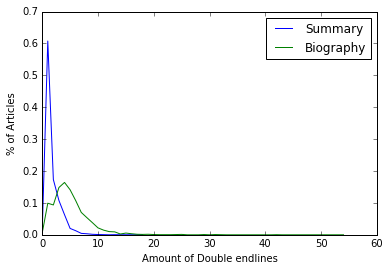

[Biography vs. Life]


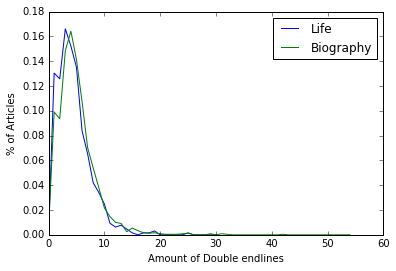

[Biography vs. Career]


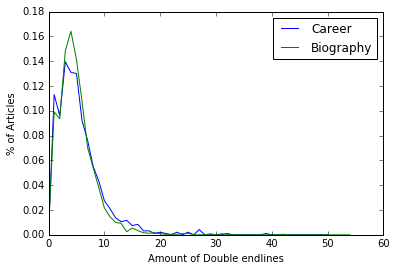

[Summary vs. Legacy]


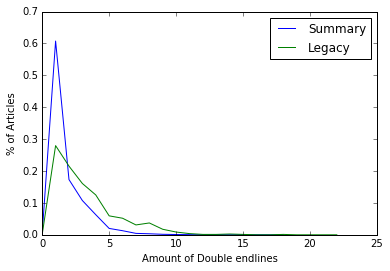

[Awards vs. Summary]


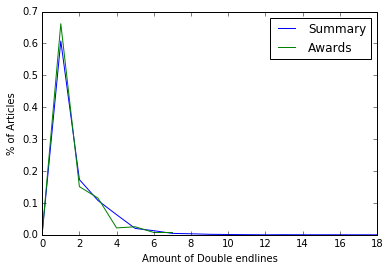

[10 most common tags]


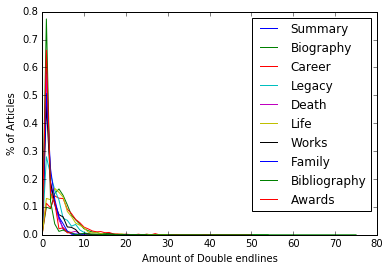

In [145]:
def plot_double_endline(data_filenames, tags): # looks for 'openings'
    X_LABEL = "Amount of Double endlines"
    Y_LABEL = "% of Articles"
    for tag in tags:
        data = lz_article_loader(data_filenames)
        amount_list = []
        max = 0
        cat_num = 0
        for [(title, doc)] in data:
            for (t, p) in doc:
                if t == tag:
                    endlines = re.findall("[^\n][\n]{2}", p)
                    amount = len(endlines)
                    amount_list.append(amount)
                    if(amount > max):
                        max = amount
                    cat_num += 1
        fd = FreqDist(amount_list)
        X_axis = list(range(max))
        Y_axis = [fd[x]/ cat_num for x in X_axis]
        py.plot(X_axis, Y_axis, label=tag)
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

print("[Summary vs. Biography]")
plot_double_endline(train_filenames, ['Summary', 'Biography'])

print("[Biography vs. Life]")
plot_double_endline(train_filenames, ['Life', 'Biography'])

print("[Biography vs. Career]")
plot_double_endline(train_filenames, ['Career', 'Biography'])

print("[Summary vs. Legacy]")
plot_double_endline(train_filenames, ['Summary', 'Legacy'])

print("[Awards vs. Summary]")
plot_double_endline(train_filenames, ['Summary', 'Awards'])

print("[10 most common tags]")
plot_double_endline(train_filenames, tags[:10])

Lets design and test our 2nd vectorizer, using some of the new features we've explored:

In [152]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
import re

# wrapper for DictVectorizer
# expects to get an iterable list of articles during fit/transform
class DictWrapper(TransformerMixin):
    def __init__(self, pars_to_features):
        self.__dict_vect__ = DictVectorizer()
        self.__pars_to_features__ = pars_to_features

    def fit(self, articles, y=None):
        acc_featues = []
        for [(article, pars)] in articles:
            acc_featues += self.__pars_to_features__(pars)
        self.__dict_vect__.fit(acc_featues)
        return self

    def transform(self, article):
        return self.__dict_vect__.transform(self.__pars_to_features__(article))

# expects to get a single wikipedia article
# extracts a dictionery of features to be used by a dictVectorizer
def pars_to_features1(article):
    months = "January|February|March|April|May|June|July|August|September|October|November|December"
    years = "[^0-9][0-2][0-9]{3,3}[^0-9]"
    
    # calculate full document's length
    full_article = ''
    for t, par in article:
        full_article += par
    full_doc_len = len(full_article.split())
    
    # find total amount of dates in article
    dates_in_article = len(re.findall(years, full_article))

    # extract normalized features
    features = []
    for i, par in enumerate(article):
        dates_in_par = len(re.findall(years, par[1]))
        norm_dates_in_par = 50
        if(dates_in_article > 0):
            norm_dates_in_par = round(50*dates_in_par/dates_in_article)
        opening = len(re.findall("([0-9] ("+months+")"+years+" ([0-9] ("+months+")"+years+"))", par[1])) == 0
        dendlines = len(re.findall("[^\n][\n]{2}", par[1]))
        
        par_len = len(par[1].split())
                      
        features.append({'POSITION': str(round(10 * (i+1 / len(article)))),
                         'DATES': str(norm_dates_in_par), # mainly to isolate the 'Biography' title from 'Summary'
                         'OPENINGS': str(opening),
                         'DENDLINES': str(dendlines)
                         })
    return features

# returns a trained vectorizer which comines both tf-idf and dict vectorizer
def train_vectorizer(train_filenames, pars_to_features):
    # tf-idf vectorizer cannot use partial fit.
    train = lz_article_loader(train_filenames)
    tf_idf_vect = TfidfWrapper()
    tf_idf_vect.fit(train)

    # same for dict-vectorizer
    train = lz_article_loader(train_filenames)
    dict_vect = DictWrapper(pars_to_features)
    dict_vect.fit(train)

    # create a unified vectorizer
    vectorizer = FeatureUnion([
        ('tf_idf_article_vectorizer', tf_idf_vect),
        ('length_and_position_vectorizer', dict_vect)
    ])
    return vectorizer

vectorizer = train_vectorizer(train_filenames, pars_to_features1) # train vectorizer
classifier = train_classifier(vectorizer, PassiveAggressiveClassifier(), train_filenames, tags) # train classifier

test = lz_article_loader(test_filenames) # recreate generator
test_classifier(vectorizer, classifier, tags, test_filenames)

Precision: 0.48342702074
Recall: 0.48342702074
F-measure: 0.48342702074
['Summary', 'Biography', 'Career', 'Legacy', 'Death', 'Life', 'Works', 'Family', 'Bibliography', 'Awards', 'Discography', 'Honours', 'Filmography', 'Books', 'Publications', 'Education', 'Background', 'Ancestry', 'Novels', 'Television']
[[1750   43    0    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  90  241   73   18    5   33    1    0    0    1    1    0    0    2
     0    0    0    0    0    0]
 [   0   44  101   23    4   10    1    3    0    0    1    0    2    1
     0    0    0    0    0    0]
 [   0   10   12   91    8    5    1    0    0    2    2    0    0    0
     0    0    0    0    0    0]
 [   0   10   10   23  109    3    0    0    0    2    0    0    1    0
     0    0    0    0    0    0]
 [   0   54   25   12    8   21    0    1    0    1    0    0    0    0
     0    0    0    0    0    0]
 [   0   11    6   30    3    8   19    1   17    3    2    0 

By exemining the confusion matrix, we can see that we've improved with some titles (Biography > Summary went from 160 to 90, Summary > Biography went from 75 to 43) but at the same time went back with other titles (Death's hits went from 52 to 45).

We'll try to improve our results by using the output of a NER tagger- specificly, Stanford's implementation with NLTK's interface. First, we'll build a basic infastructuer-

In [86]:
from nltk.tag.stanford import StanfordNERTagger
import os

STANFORD_PATH = 'C:\\Users\\YUVAL\\OneDrive\\stanford-ner\\classifiers'
CLASS_PATH = 'C:\\Users\\YUVAL\\OneDrive\\stanford-ner\\stanford-ner.jar'
JAVA_PATH = 'C:/Program Files/Java/jdk1.8.0_73/bin/java.exe'

def extract_ner_list(tag, data_filenames, samples=200):
    # config ner tagger
    os.environ['JAVAHOME'] = JAVA_PATH
    os.environ['STANFORD_MODELS'] = STANFORD_PATH
    os.environ['CLASSPATH'] = CLASS_PATH
    ner_tagger = StanfordNERTagger("english.all.3class.distsim.crf.ser.gz")
    
    # load data
    data = lz_article_loader(data_filenames)
    ans = []
    seen = 0
    for [(title, doc)] in data:
        for (t, p) in doc:
            if t == tag:
                tokens = p.split()
                tagged = ner_tagger.tag(tokens)
                ner = [ner for word, ner in tagged]
                fd = FreqDist(ner)
                ans.append(fd)
                seen += 1
        if(seen == samples):
            break
    return ans

summary_ner_200 = extract_ner_list('Summary', train_filenames)
biography_ner_200 = extract_ner_list('Biography', train_filenames)
life_ner_200 = extract_ner_list('Life', train_filenames)
career_ner_200 = extract_ner_list('Career', train_filenames)
legacy_ner_200 = extract_ner_list('Legacy', train_filenames)

We'll plot the amount of ner tags for each categorie-

[PERSON tag]


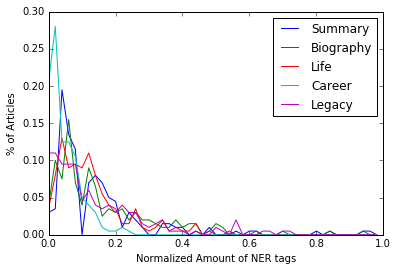

[LOCATION tag]


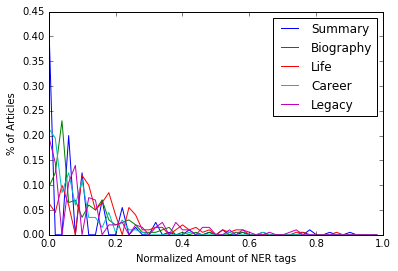

[ORGANIZATION tag]


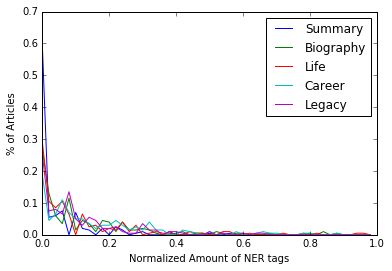

In [155]:
def plot_amount_of_ner_tags(ner_tag, ner_lists, tags, buckets):
    X_LABEL = "Normalized Amount of NER tags"
    Y_LABEL = "% of Articles"
    for i, ner_list in enumerate(ner_lists):
        raw_ner = [l[ner_tag] for l in ner_list]
        max_ner = max(raw_ner)
        samples = len(ner_list)
        normalized = [round(buckets*x/max_ner) for x in raw_ner]
        fd = FreqDist(normalized)
        X_axis = [x/buckets for x in range(buckets)]
        Y_axis = [fd[x]/samples for x in range(buckets)]
        py.plot(X_axis, Y_axis, label=tags[i])
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

sub_tags = ['Summary', 'Biography', 'Life', 'Career', 'Legacy']
ner_list = [summary_ner_200, biography_ner_200, life_ner_200, career_ner_200, legacy_ner_200]

print("[PERSON tag]")
plot_amount_of_ner_tags('PERSON', ner_list, sub_tags, 50)

print("[LOCATION tag]")
plot_amount_of_ner_tags('LOCATION', ner_list, sub_tags, 50)

print("[ORGANIZATION tag]")
plot_amount_of_ner_tags('ORGANIZATION', ner_list, sub_tags, 50)

We can see that in relation to PERSON tag, some of the titles tends to behave a bit differently then the others (specificly Summary and Career, where PERSON tag is relativley less common then the others).
Next, we'll try to look at the divergence of different NER tags by exemining at theire distribution entropy-

[Summary vs. Biography]


C:\Users\YUVAL\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: divide by zero encountered in log2
C:\Users\YUVAL\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


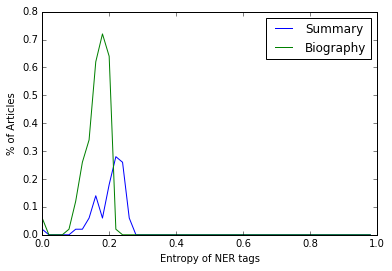

[Biography vs. Life]


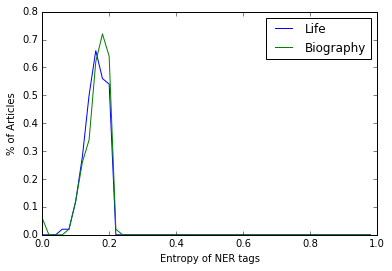

[Biography vs. Career]


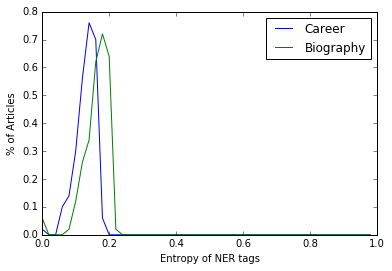

[Summary vs. Legacy]


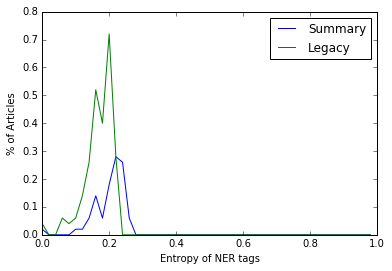

[All 5]


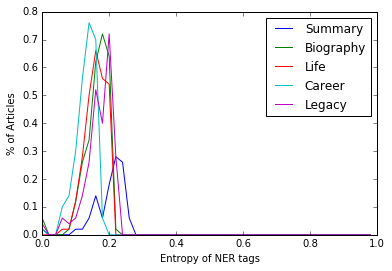

In [136]:
import numpy as np

def plot_entropy_of_ner_tags(ner_tags, ner_lists, tags, buckets):
    X_LABEL = "Entropy of NER tags"
    Y_LABEL = "% of Articles"
    for i, ner_list in enumerate(ner_lists):
        entropy_list = []
        max_norm = 0
        for l in ner_list:
            entropy = 0
            sum_n = 0
            for ner_tag in ner_tags:
                sum_n += l[ner_tag]
            if sum_n > max_norm:
                max_norm = sum_n
            if(sum_n != 0):
                for ner_tag in ner_tags:
                    ner_tag_p = l[ner_tag]/sum_n
                    entropy -= ner_tag_p*np.log2(ner_tag_p)
            entropy_list.append(entropy)
        norm_parm = np.log2(max_norm)
        normalized = [round(buckets*x/norm_parm) for x in entropy_list]
        fd = FreqDist(normalized)
        X_axis = [x/buckets for x in range(buckets)]
        Y_axis = [fd[x]/buckets for x in range(buckets)]
        py.plot(X_axis, Y_axis, label=tags[i])
    py.xlabel(X_LABEL)
    py.ylabel(Y_LABEL)
    py.legend(loc='upper right')
    py.show()

ner_tags = ['PERSON', 'LOCATION', 'ORGANIZATION']

print("[Summary vs. Biography]")
plot_entropy_of_ner_tags(ner_tags, [summary_ner_200, biography_ner_200], ['Summary', 'Biography'], 50)

print("[Biography vs. Life]")
plot_entropy_of_ner_tags(ner_tags, [life_ner_200, biography_ner_200], ['Life', 'Biography'], 50)

print("[Biography vs. Career]")
plot_entropy_of_ner_tags(ner_tags, [career_ner_200, biography_ner_200], ['Career', 'Biography'], 50)

print("[Summary vs. Legacy]")
plot_entropy_of_ner_tags(ner_tags, [summary_ner_200, legacy_ner_200], ['Summary', 'Legacy'], 50)

print("[All 5]")
plot_entropy_of_ner_tags(ner_tags, ner_list, sub_tags, 50)

We can clearly see that Summary tends to have much less diversity in relation to NER tags, and so we can use this feature to identify it from the rest of the paragraphs. Lets design our 3rd tokenizer:

In [ ]:
# expects to get a single wikipedia article
# extracts a dictionery of features to be used by a dictVectorizer

# config ner tagger
os.environ['JAVAHOME'] = JAVA_PATH
os.environ['STANFORD_MODELS'] = STANFORD_PATH
os.environ['CLASSPATH'] = CLASS_PATH
ner_tagger = StanfordNERTagger("english.all.3class.distsim.crf.ser.gz")

def pars_to_features2(article):
    months = "January|February|March|April|May|June|July|August|September|October|November|December"
    years = "[^0-9][0-2][0-9]{3,3}[^0-9]"
    PER_normalize = 450
    norm_entropy = np.log2(3)
    
    # calculate full document's length
    full_article = ''
    for t, par in article:
        full_article += par
    full_doc_len = len(full_article.split())
    
    # find total amount of dates in article
    dates_in_article = len(re.findall(years, full_article))

    # extract normalized features
    features = []
    for i, par in enumerate(article):
        dates_in_par = len(re.findall(years, par[1]))
        norm_dates_in_par = 50
        if(dates_in_article > 0):
            norm_dates_in_par = round(50*dates_in_par/dates_in_article)
        opening = len(re.findall("([0-9] ("+months+")"+years+" ([0-9] ("+months+")"+years+"))", par[1])) == 0
        dendlines = len(re.findall("[^\n][\n]{2}", par[1]))
        
        tokens = par[1].split()
        tagged = ner_tagger.tag(tokens)
        ner_tags = [ner for w, ner in tagged]
        per_count = ner_tags.count('PERSON')
        loc_count = ner_tags.count('LOCATION')
        org_count = ner_tags.count('ORGANIZATION')
        ner_count = per_count+loc_count+org_count
        entropy = 0
        if(ner_count > 0):
            per_p = per_count/ner_count
            loc_p = loc_count/ner_count
            org_p = org_count/ner_count
            entropy = -per_p*np.log2(per_p)-loc_p*np.log2(loc_p)-org_p*np.log2(org_p)
        
        par_len = len(par[1].split())
                      
        features.append({'POSITION': str(round(10 * (i+1 / len(article)))),
                         'DATES': str(norm_dates_in_par), # mainly to isolate the 'Biography' title from 'Summary'
                         'OPENINGS': str(opening),
                         'DENDLINES': str(dendlines),
                         'PER_NER': str(round(50*per_count/PER_normalize)),
                         'ENT_NER': str(round(50*entropy/norm_entropy))
                         })
    return features

vectorizer = train_vectorizer(train_filenames, pars_to_features2) # train vectorizer
classifier = train_classifier(vectorizer, PassiveAggressiveClassifier(), train_filenames, tags) # train classifier

test = lz_article_loader(test_filenames) # recreate generator
test_classifier(vectorizer, classifier, tags, test_filenames)

And finally, let's use our classifier with the output of the segmantation process and test the results. First, we'll write a simple evaluation method which is based on tokenizing each article by sentences and then checking how many sentences are attched to the correct title-

In [ ]:
from nltk import sent_tokenize

def pars_to_sents(pars):
    ans = []
    for title, par in pars:
        sents = sent_tokenize(par)
        ans += [(sent, title) for sent in sents]
    return ans

def sent_eval(gold, predictions):
    TP, ALL = 0, 0
    for g_art, p_art in zip(gold, predictions):
        gold_pairs = pars_to_sents(g_art)
        pred_pairs = pars_to_sents(p_art)
        if(len(gold_pairs) ==  len(pred_pairs)):
            ALL += len(gold_pairs)
            for g_sent, p_sent in zip(gold_pairs, pred_pairs):
                if(g_sent[1] == p_sent[1]):
                    TP += 1
    return TP/ALL

Next, we'll test the classifier on the segmentation's output and evaluate the results - 

In [ ]:
gold_raw = lz_article_loader("corpus18000.pickle")
gold = [pars for [(title, pars)] in gold_raw]
pred_raw = lz_article_loader("corpus18000_seg.pickle")
pred = []
for [(article, pars)] in pred_raw:
    titles = classifier.predict(vectorizer.transform(pars)).tolist()
    text = [p for (t, p) in pars]
    pred.append([(t, p) for (t, p) in zip(titles, text)])

print("Evaluation Score: %f", sent_eval(gold, pred))